<a href="https://colab.research.google.com/github/Balantekin/python/blob/main/Week3_TreebasedRegressors_Student_notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='red'>Model Building And Validation</font>
## <font color='blue'>Session-3 Decision Tree Regressor and LGBM Regressor Examples</font>
### <font color='blue'>Part-1 Preperations</font>

### We will continue to use London bike rental data for today's regression tasks.

### Our goal is to build tree based models and compare them with the linear regression model we've built before.

In [ ]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import random

import lightgbm as lgb
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_log_error
from sklearn import metrics

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")



In [ ]:
def log_transform(s, reverse=False):
    if reverse:
        return np.exp(s)-1
    else:
        return np.log(s+1)


def ansc_transform(s, reverse=False):
    if reverse:
        return ((s/2)**2)-0.375
    else:
        return np.sqrt(s+0.375)*2


def no_transform(s, reverse=False):
    return s


def frmn_transform(s, reverse=False):
    if reverse:
        return (s/2)**2
    else:
        return np.sqrt(s+1)+np.sqrt(s)


transforms = {'none':no_transform, 'log': log_transform, 'anscombe': ansc_transform, 'freeman': frmn_transform}

def transform_target(df, method):
    target = 'target_'+method
    df[target] = transforms[method](df['cnt'])
    return df, target


def add_commute(df, features, ordinal=False):
    if not ordinal:
        df['commute'] = (df['is_weekend']==0) & df['timeofday'].isin([7,8,9,17,18])
        features.append('commute')
    else:
        df['commute'] = 0
        df.loc[((df['is_weekend']==0) & df['timeofday'].isin([7,9,16,19])),'commute'] = 1
        df.loc[((df['is_weekend']==0) & df['timeofday'].isin([17,18])),'commute'] = 2
        df.loc[((df['is_weekend']==0) & df['timeofday'].isin([8])),'commute'] = 3

    features.append('commute')
    return df, features



def add_sleeptime(df, features):
    df['sleeptime'] = (df['timeofday'].isin([0,1,2,3,4,5,23]))
    features.append('sleeptime')
    return df, features



def encode_timeofday(source, dataframes, features):
    print('target mean encoding;')
    for df in dataframes:
        df['tmc_tod'] = 0
    for tod in range(24):
        val = source.loc[source['timeofday']==tod, 'cnt'].mean()
        for df in dataframes:
            df.loc[df['timeofday']==tod, 'tmc_tod'] = val
    features.remove('timeofday')
    features.append('tmc_tod')
    return dataframes, features



def eliminate_outliers(df):
    df['outlier'] = 0
    df.loc[df['cnt']>5600,'outlier'] = 1
    df.iloc[8382:8720].outlier = 1
    df = df[df['outlier']==0]
    df.reset_index(drop=True,inplace=True)
    return df


def split_oot(df, ratio):
    L = len(df)
    split_index = int(L*ratio)
    train = df.iloc[:split_index]
    test = df.iloc[split_index:]
    print(train.shape, test.shape)
    return train, test

def split_oos(df, ratio):
    return train_test_split(df, test_size=(1-ratio), random_state=42)


def split_data(df, split="oot", ratio=0.7):
    splits = {'oot':split_oot, 'oos':split_oos}
    train, test = splits[split](df, ratio)
    return train, test


def preprocess(df, encode_weather=True, encode_season=True, commute=True, sleep=True, elim_outliers=True):
    features = ['t1', 'hum', 'weather_code', 'wind_speed', "season", 'is_holiday', 'is_weekend']

    df['timeofday'] = pd.to_datetime(df['timestamp']).dt.hour
    features.append('timeofday')
    if commute:
        df, features = add_commute(df, features, True)
    if sleep:
        df, features = add_sleeptime(df, features)

    if encode_weather:
        df['wc_1'] = df.weather_code==1
        df['wc_2'] = df.weather_code==2
        df['wc_3'] = df.weather_code==3
        df['wc_4'] = df.weather_code==4
        df['wc_7'] = df.weather_code==7
        df['wc_10'] = df.weather_code==10
        #df['wc_26'] = df.weather_code==26
        features.remove('weather_code')
        features.extend(['wc_1', 'wc_2', 'wc_3', 'wc_4', 'wc_7', 'wc_10'])

    if encode_season:
        df['s_0'] = df.season==0
        df['s_1'] = df.season==1
        df['s_2'] = df.season==2
        #df['s_3'] = df.season==3

        features.remove('season')
        features.extend(['s_0','s_1', 's_2'])

    if elim_outliers:
        df = eliminate_outliers(df)


    return df, features



# OOS vs OOT split


In [ ]:
#choose a transform
transform = 'none'

df = pd.read_csv('bikes_london.csv')
df, target = transform_target(df, transform)
df, features = preprocess(df)

# seperate the dataset over time in two as a workset (first %80) and a holdout set (last %20)
# this holdout set will serve as a final validation set to measure between different approaches
workset , holdout = split_oot(df, 0.8)
# YOUR CODE



(13655, 24) (3414, 24)


In [ ]:
workset

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,target_none,timeofday,commute,sleeptime,wc_1,wc_2,wc_3,wc_4,wc_7,wc_10,s_0,s_1,s_2,outlier
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,182,0,0,True,False,False,True,False,False,False,False,False,False,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,138,1,0,True,True,False,False,False,False,False,False,False,False,0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,134,2,0,True,True,False,False,False,False,False,False,False,False,0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,72,3,0,True,True,False,False,False,False,False,False,False,False,0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,47,4,0,True,True,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13650,2016-08-12 19:00:00,2619,24.5,24.5,47.0,26.0,1.0,0.0,0.0,1.0,2619,19,1,False,True,False,False,False,False,False,False,True,False,0
13651,2016-08-12 20:00:00,1902,22.0,22.0,56.5,27.0,1.0,0.0,0.0,1.0,1902,20,0,False,True,False,False,False,False,False,False,True,False,0
13652,2016-08-12 21:00:00,1212,19.5,19.5,62.0,30.0,1.0,0.0,0.0,1.0,1212,21,0,False,True,False,False,False,False,False,False,True,False,0
13653,2016-08-12 22:00:00,1004,18.5,18.5,64.0,27.0,1.0,0.0,0.0,1.0,1004,22,0,False,True,False,False,False,False,False,False,True,False,0


In [ ]:
# With our workset, lets try a Out of sample split of 75/25
workset_oos_train, workset_oos_test = split_oos(workset, 0.75)
X = workset_oos_train[features]
y = workset_oos_train['cnt']
# Train a decision tree regressor using train test
regressor = DecisionTreeRegressor(random_state=0)

# Evaluate model with test set
model = regressor.fit(X,y)


In [ ]:
X

,t1,hum,wind_speed,is_holiday,is_weekend,timeofday,commute,sleeptime,wc_1,wc_2,wc_3,wc_4,wc_7,wc_10,s_0,s_1,s_2
1845,6.0,78.5,13.0,0.0,1.0,23,0,True,False,False,True,False,False,False,True,False,False
8794,6.5,66.0,15.0,0.0,0.0,16,1,False,True,False,False,False,False,False,False,False,False
111,9.0,71.0,19.5,0.0,0.0,16,1,False,False,True,False,False,False,False,False,False,False
472,4.0,75.0,14.0,0.0,0.0,17,2,False,True,False,False,False,False,False,False,False,False
6906,9.0,90.5,6.0,0.0,0.0,8,3,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,16.0,77.0,8.0,0.0,1.0,5,0,True,True,False,False,False,False,False,False,True,False
13418,20.0,83.0,23.0,0.0,0.0,2,0,True,False,False,False,True,False,False,False,True,False
5390,19.5,40.0,13.0,0.0,0.0,12,0,False,True,False,False,False,False,False,False,True,False
860,5.0,78.5,14.0,0.0,1.0,21,0,False,True,False,False,False,False,False,False,False,False


In [ ]:
# Now try a Out of time split 75/25 with same workset
workset_oot_train, workset_oot_test = split_oot(workset, 0.75)
X2 = workset_oot_train[features]
y2 = workset_oot_train['cnt']

# Train a decision tree regressor using train test
regressor2 = DecisionTreeRegressor(random_state=1)

# Evaluate model with test set
model2 = regressor2.fit(X2,y2)


(10241, 24) (3414, 24)


In [ ]:
# Now evaluate both models against the holdout set

X_test = workset_oos_test[features]
y_test = workset_oos_test['cnt']
# YOUR CODE
y_pred = model.predict(X_test)


In [ ]:
result = r2_score(y_test, y_pred)
result

0.9248341692277744

In [ ]:
X2_test = workset_oot_test[features]
y2_test = workset_oot_test['cnt']
# YOUR CODE
y_pred2 = model.predict(X2_test)

In [ ]:
result2 = r2_score(y2_test, y_pred2)
result2

0.9797240239199992

In [ ]:
X_holdout = holdout[features]
y_holdout = holdout['cnt']
# YOUR CODE
holdout_pred = model.predict(X_holdout)
holdout_pred2 = model2.predict(X_holdout)

In [ ]:
result_h = r2_score(y_holdout, holdout_pred)
result_h

0.8679677004696437

In [ ]:
result_h2 = r2_score(y_holdout, holdout_pred2)
result_h2

0.8663001666081771

ilk başta workset zaman gore ilk %80 lık kısım olaak sekılde veri seti 2 ye bolundu.
Workset verı setı kendı ıcınde traın ve test olacak sekılde %75 oranında olacak sekılde oot ve oos methodlarıyle ıkıye ayrıldı. sonrasında decısıon tree modelı kulanarak ıkı farklı methodla ayrılan traın datasetlerı kullanılarak tahmınleme calısması yapıldı. Bunların test performanslarında zamana gore ayrılan model daha ıyı sonuc verdıgı goruldu(oot). Ancak holdout verı setı ıle bu egıtılen modellerın tahmınleme performanslarına bakıldıgında oot daha kotu performans gosterdı. Bunun nedenı rastgele secılen datasetının holdout verı etıne daha yakın zamandakı verılerı ıcermesı etkılı olmus olabılır dıye dusunuyoruz.

In [ ]:
# Comment on your observations
#When dataset was occured via oot split method, the model result gets higher number due to the timeline period.
#Oos method has slightly lower result because of the using dataset which comes from mixture time preiod.
# Your comments



# Model Selection

In [ ]:

def Apply_CrossValidation(model, split_choice, data, features, target, metric = 'MSE', params=None):

    if split_choice == 'oot':
        fold = TimeSeriesSplit(max_train_size=None, n_splits=10)

        results = []
        for i_train, i_test in fold.split(data):

            X_train, Y_train = data.iloc[i_train][features], data.iloc[i_train][target]
            X_test, Y_test = data.iloc[i_test][features], data.iloc[i_test][target]

            regr = model() if params is None else model(**params)
            fold_model = regr.fit(X_train, Y_train)

            pred = fold_model.predict(X_test)

            if metric == 'MSE':
                result = mean_squared_error(Y_test, pred)
            elif metric == 'MAE':
                result = mean_absolute_error(Y_test, pred)
            elif metric == 'R2':
                result = r2_score(Y_test, pred)
            else:
                result = (mean_squared_error(Y_test, pred)**0.5)

            results.append(result)

            print("Train: ", data.iloc[i_train]["timestamp"].min(), ' / ', data.iloc[i_train]["timestamp"].max(),
                 "------- Test: ", data.iloc[i_test]["timestamp"].min(), ' / ', data.iloc[i_test]["timestamp"].max())

        print('Mean of scores: ', np.mean(results))
        print('Std of scores: ', np.std(results))

        return results


    elif split_choice == 'tbs': #time based random sampling
        train, test = split_oot(data, 0.7)

        results = []
        for d in [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]:
            tr_fold = train.sample(frac = 0.5, random_state = d)
            test_fold = test.sample(frac = 0.5, random_state = d)

            regr = model() if params is None else model(**params)
            fold_model = regr.fit(tr_fold[features], tr_fold[target])

            pred = fold_model.predict(test_fold[features])

            if metric == 'MSE':
                result = mean_squared_error(test_fold[target], pred)
            elif metric == 'MAE':
                result = mean_absolute_error(test_fold[target], pred)
            elif metric == 'R2':
                result = r2_score(test_fold[target], pred)
            else:
                result = (mean_squared_error(test_fold[target], pred)**0.5)

            results.append(result)

            print("Train: ", tr_fold["timestamp"].min(), ' / ', tr_fold["timestamp"].max(),
                 "------- Test: ", test_fold["timestamp"].min(), ' / ', test_fold["timestamp"].max())

        print('Mean of scores: ', np.mean(results))
        print('Std of scores: ', np.std(results))

        return results


def experiment(exp_name, model, params):
    # Let's keep these as constant between model experiments
    transform='freeman' # 'none', 'log', 'anscombe', 'freeman'
    split_choice='oot' # 'oot', 'tbs' (time based random split)
    metric='R2' # 'MSE', 'MAE', 'R2'
    encode_weather=True
    encode_season=True
    commute=False
    sleep=True
    elim_outliers=True

    df = pd.read_csv('bikes_london.csv')
    df, target = transform_target(df, transform)
    df, features = preprocess(df, encode_weather, encode_season, commute,
               sleep, elim_outliers)
    print(exp_name)
    results = Apply_CrossValidation(model=model, params=params, split_choice=split_choice,
                                    data=df, features=features, target=target, metric=metric)
    return results



In [ ]:
exp1 = experiment(exp_name="Linear regression", model=linear_model.LinearRegression, params=None)

print(exp1)

Linear regression
Train:  2015-01-04 00:00:00  /  2015-03-10 00:00:00 ------- Test:  2015-03-10 01:00:00  /  2015-05-13 21:00:00
Train:  2015-01-04 00:00:00  /  2015-05-13 21:00:00 ------- Test:  2015-05-13 22:00:00  /  2015-07-17 20:00:00
Train:  2015-01-04 00:00:00  /  2015-07-17 20:00:00 ------- Test:  2015-07-17 21:00:00  /  2015-09-21 02:00:00
Train:  2015-01-04 00:00:00  /  2015-09-21 02:00:00 ------- Test:  2015-09-21 03:00:00  /  2015-11-25 09:00:00
Train:  2015-01-04 00:00:00  /  2015-11-25 09:00:00 ------- Test:  2015-11-25 10:00:00  /  2016-02-12 14:00:00
Train:  2015-01-04 00:00:00  /  2016-02-12 14:00:00 ------- Test:  2016-02-12 15:00:00  /  2016-04-17 22:00:00
Train:  2015-01-04 00:00:00  /  2016-04-17 22:00:00 ------- Test:  2016-04-17 23:00:00  /  2016-06-21 13:00:00
Train:  2015-01-04 00:00:00  /  2016-06-21 13:00:00 ------- Test:  2016-06-21 14:00:00  /  2016-08-26 02:00:00
Train:  2015-01-04 00:00:00  /  2016-08-26 02:00:00 ------- Test:  2016-08-26 03:00:00  /  201

In [ ]:

exp2 = experiment(exp_name="Decision Tree", model=DecisionTreeRegressor, params= None)

print(exp2)

Decision Tree
Train:  2015-01-04 00:00:00  /  2015-03-10 00:00:00 ------- Test:  2015-03-10 01:00:00  /  2015-05-13 21:00:00
Train:  2015-01-04 00:00:00  /  2015-05-13 21:00:00 ------- Test:  2015-05-13 22:00:00  /  2015-07-17 20:00:00
Train:  2015-01-04 00:00:00  /  2015-07-17 20:00:00 ------- Test:  2015-07-17 21:00:00  /  2015-09-21 02:00:00
Train:  2015-01-04 00:00:00  /  2015-09-21 02:00:00 ------- Test:  2015-09-21 03:00:00  /  2015-11-25 09:00:00
Train:  2015-01-04 00:00:00  /  2015-11-25 09:00:00 ------- Test:  2015-11-25 10:00:00  /  2016-02-12 14:00:00
Train:  2015-01-04 00:00:00  /  2016-02-12 14:00:00 ------- Test:  2016-02-12 15:00:00  /  2016-04-17 22:00:00
Train:  2015-01-04 00:00:00  /  2016-04-17 22:00:00 ------- Test:  2016-04-17 23:00:00  /  2016-06-21 13:00:00
Train:  2015-01-04 00:00:00  /  2016-06-21 13:00:00 ------- Test:  2016-06-21 14:00:00  /  2016-08-26 02:00:00
Train:  2015-01-04 00:00:00  /  2016-08-26 02:00:00 ------- Test:  2016-08-26 03:00:00  /  2016-10

In [ ]:
# Compare these two models and select the better model
#Decision tree get higher results .....
# YOUR CODE HERE



In [ ]:
# Comments On selection
#DECISION TREE REGRESSOR HAS BETTER MEAN OF SCORES (0.9131)

# Model Tuning

In [ ]:
exp3 = experiment(exp_name="Decision Tree", model=DecisionTreeRegressor, params= params)

print(exp3)

NameError: ignored

In [ ]:
exp4 = experiment(exp_name="Decision Tree", model=DecisionTreeRegressor, params= params1)

print(exp4)

In [ ]:
exp5 = experiment(exp_name="Decision Tree", model=DecisionTreeRegressor, params= params2)

print(exp5)

In [ ]:
exp6 = experiment(exp_name="Decision Tree", model=DecisionTreeRegressor, params= params3)

print(exp6)

In [ ]:
exp7 = experiment(exp_name="Decision Tree", model=DecisionTreeRegressor, params= params4)

print(exp7)

In [ ]:
# Try to achieve a better score using different parameters
params = {
            "min_samples_split": 102,
            "max_depth": 99,
            "min_samples_leaf": 500,
            "max_leaf_nodes": 9999

        }

# Choose top 2 parameter sets from your trials and compare these two and select the better parameter set

# YOUR CODE HERE

In [ ]:
# Try to achieve a better score using different parameters
params1 = {
            "min_samples_split": 2,
            "max_depth": 99,
            "min_samples_leaf": 6,
            "max_leaf_nodes": 9999

        }

# Choose top 2 parameter sets from your trials and compare these two and select the better parameter set

# YOUR CODE HERE


In [ ]:
# Try to achieve a better score using different parameters
params2 = {
            "min_samples_split": 2,
            "max_depth": 10,
            "min_samples_leaf": 6,
            "max_leaf_nodes": 9999

        }

# Choose top 2 parameter sets from your trials and compare these two and select the better parameter set

# YOUR CODE HERE

In [ ]:
# Try to achieve a better score using different parameters
params3 = {
            "min_samples_split": 2,
            "max_depth": 99,
            "min_samples_leaf": 6,
            "max_leaf_nodes": 9999

        }

# Choose top 2 parameter sets from your trials and compare these two and select the better parameter set

# YOUR CODE HERE

In [ ]:
# Try to achieve a better score using different parameters
params4 = {
            "min_samples_split": 2,
            "max_depth": 20,
            "min_samples_leaf": 6,
            "max_leaf_nodes": 9999

        }

# Choose top 2 parameter sets from your trials and compare these two and select the better parameter set

# YOUR CODE HERE

In [ ]:
# give a definition for the above parameters and describe how they effect the training and results

#"min_samples_split":  minimum number of samples required to split an internal node
#"max_depth": represents the depth of each tree
#"min_samples_leaf": The minimum number of samples required to be at a leaf node
#"max_leaf_nodes": The maximum number of leaf nodes

# lowering the min_samples_split and min_samples_leaf parameters increased the mean of scores.


# Automated hyper parameter search


In [ ]:
# Select some values for parameter search
param_grid = {
              "min_samples_split": [2, 3, 10],
              "max_depth": [3, None],
              "min_samples_leaf": [2, 3,10],
              "max_leaf_nodes": [21, 99]
              }

# Use RandomizedSearchCV to find best parameters for your model
# use DecisionTreeRegressor, MSE and your choice of split

# YOUR CODE HERE
random_search = RandomizedSearchCV(regressor, param_grid)
random_search.fit(X2, y2)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort='deprecated',
                                                   random_state=0,
                                                   splitter='best'),
                   iid='d

In [ ]:
# Print the best parameters and the best score achieved

# YOUR CODE
print(random_search.best_params_)


{'min_samples_split': 3, 'min_samples_leaf': 3, 'max_leaf_nodes': 99, 'max_depth': None}


# Final training with best parameters


In [ ]:
# Now that you have found best parameters,
# train a final model using train set and validate it with test and holdout sets

# YOUR CODE

best_params = {
            "min_samples_split": 10,
            "max_depth": None,
            "min_samples_leaf": 3,
            "max_leaf_nodes": 99

        }

best_exp = experiment(exp_name="Decision Tree", model=DecisionTreeRegressor, params= best_params)

print(best_exp)


Decision Tree
Train:  2015-01-04 00:00:00  /  2015-03-10 00:00:00 ------- Test:  2015-03-10 01:00:00  /  2015-05-13 21:00:00
Train:  2015-01-04 00:00:00  /  2015-05-13 21:00:00 ------- Test:  2015-05-13 22:00:00  /  2015-07-17 20:00:00
Train:  2015-01-04 00:00:00  /  2015-07-17 20:00:00 ------- Test:  2015-07-17 21:00:00  /  2015-09-21 02:00:00
Train:  2015-01-04 00:00:00  /  2015-09-21 02:00:00 ------- Test:  2015-09-21 03:00:00  /  2015-11-25 09:00:00
Train:  2015-01-04 00:00:00  /  2015-11-25 09:00:00 ------- Test:  2015-11-25 10:00:00  /  2016-02-12 14:00:00
Train:  2015-01-04 00:00:00  /  2016-02-12 14:00:00 ------- Test:  2016-02-12 15:00:00  /  2016-04-17 22:00:00
Train:  2015-01-04 00:00:00  /  2016-04-17 22:00:00 ------- Test:  2016-04-17 23:00:00  /  2016-06-21 13:00:00
Train:  2015-01-04 00:00:00  /  2016-06-21 13:00:00 ------- Test:  2016-06-21 14:00:00  /  2016-08-26 02:00:00
Train:  2015-01-04 00:00:00  /  2016-08-26 02:00:00 ------- Test:  2016-08-26 03:00:00  /  2016-10

In [ ]:
# Print number of nodes and max depth of your tree model

# YOUR CODE


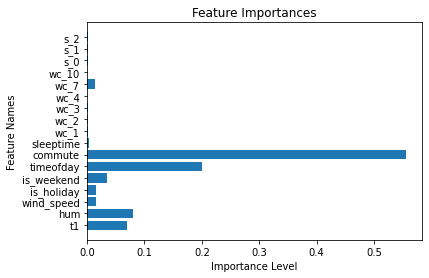

In [ ]:
# Use a bar plot to visualize feature importances of model

# YOUR CODE

plt.barh(features,model.feature_importances_)
plt.title('Feature Importances')
plt.ylabel('Feature Names')
plt.xlabel('Importance Level')
plt.show()

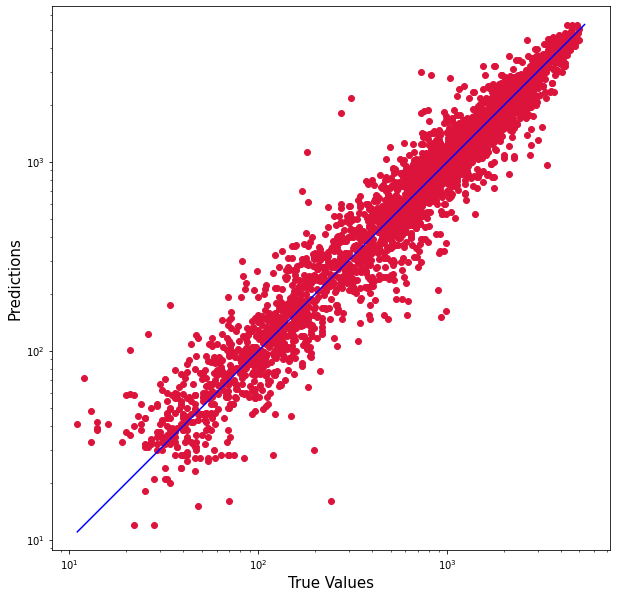

In [ ]:
# Use a scatter to plot actual vs predicted values

# YOUR CODE
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

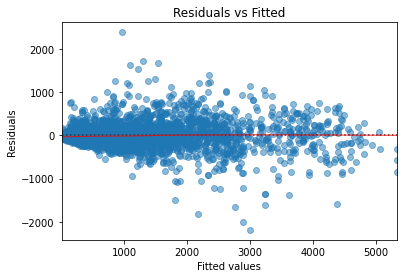

In [ ]:
# Visualize residual vs fitted value


plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(y_pred, y_test,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

In [ ]:
# Compare decision tree test results with linear regression test results. Which one performed better? Why

#DECISION TREE REGRESSOR GET BETTER RESULTS BECAUSE, LINEAR REGRESSION CAN ONLY SUPPORT LINEAR RELATIONS.
#ON THE OTHER HAND DECISION TREE REGRESSOR CAN SUPPORT NON-LINEAR RELATIONS.



# Part 4  LightGBM Gradient boosted decision tree regressor


In [ ]:
# Do the same steps above with LightGBM regressor
from lightgbm import LGBMRegressor

In [ ]:
# Model tuning
lgmb_model=LGBMRegressor

exp1 = experiment(exp_name="Lgbm", model=lgmb_model, params=None)

print(exp1)




# Automated hyper parameter search
grid_params = {'n_estimators': [8, 24],
                   'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt','dart'],
                   'seed': [500],
                   'colsample_bytree': [0.65, 0.75, 0.8],
                   'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]}

mod = lgb.LGBMRegressor()




#random_search = RandomizedSearchCV(lgmb_model, grid_params)
#random_search.fit(X2, y2)

grid = GridSearchCV(mod, param_grid=grid_params, verbose=1, cv=5, n_jobs=-1)
grid.fit(X, y)
y_pred=grid.predict(X_test)

# Train final model

# Validate and visualize model



Lgbm
Train:  2015-01-04 00:00:00  /  2015-03-10 00:00:00 ------- Test:  2015-03-10 01:00:00  /  2015-05-13 21:00:00
Train:  2015-01-04 00:00:00  /  2015-05-13 21:00:00 ------- Test:  2015-05-13 22:00:00  /  2015-07-17 20:00:00
Train:  2015-01-04 00:00:00  /  2015-07-17 20:00:00 ------- Test:  2015-07-17 21:00:00  /  2015-09-21 02:00:00
Train:  2015-01-04 00:00:00  /  2015-09-21 02:00:00 ------- Test:  2015-09-21 03:00:00  /  2015-11-25 09:00:00
Train:  2015-01-04 00:00:00  /  2015-11-25 09:00:00 ------- Test:  2015-11-25 10:00:00  /  2016-02-12 14:00:00
Train:  2015-01-04 00:00:00  /  2016-02-12 14:00:00 ------- Test:  2016-02-12 15:00:00  /  2016-04-17 22:00:00
Train:  2015-01-04 00:00:00  /  2016-04-17 22:00:00 ------- Test:  2016-04-17 23:00:00  /  2016-06-21 13:00:00
Train:  2015-01-04 00:00:00  /  2016-06-21 13:00:00 ------- Test:  2016-06-21 14:00:00  /  2016-08-26 02:00:00
Train:  2015-01-04 00:00:00  /  2016-08-26 02:00:00 ------- Test:  2016-08-26 03:00:00  /  2016-10-31 07:00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 716 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 3116 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  2.3min finished


In [ ]:
print(grid.best_params_)


{'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'n_estimators': 24, 'num_leaves': 16, 'reg_alpha': 6, 'reg_lambda': 1, 'seed': 500, 'subsample': 0.7}


In [ ]:
best_params_lgbm={'boosting_type': 'gbdt', 'colsample_bytree': 0.75, 'learning_rate': 0.01, 'n_estimators': 24, 'num_leaves': 16, 'reg_alpha': 1, 'reg_lambda': 1, 'seed': 500, 'subsample': 0.7}

In [ ]:
exp1_best= experiment(exp_name="Lgbm", model=lgmb_model, params=best_params_lgbm)

print(exp1_best)

Lgbm
Train:  2015-01-04 00:00:00  /  2015-03-10 00:00:00 ------- Test:  2015-03-10 01:00:00  /  2015-05-13 21:00:00
Train:  2015-01-04 00:00:00  /  2015-05-13 21:00:00 ------- Test:  2015-05-13 22:00:00  /  2015-07-17 20:00:00
Train:  2015-01-04 00:00:00  /  2015-07-17 20:00:00 ------- Test:  2015-07-17 21:00:00  /  2015-09-21 02:00:00
Train:  2015-01-04 00:00:00  /  2015-09-21 02:00:00 ------- Test:  2015-09-21 03:00:00  /  2015-11-25 09:00:00
Train:  2015-01-04 00:00:00  /  2015-11-25 09:00:00 ------- Test:  2015-11-25 10:00:00  /  2016-02-12 14:00:00
Train:  2015-01-04 00:00:00  /  2016-02-12 14:00:00 ------- Test:  2016-02-12 15:00:00  /  2016-04-17 22:00:00
Train:  2015-01-04 00:00:00  /  2016-04-17 22:00:00 ------- Test:  2016-04-17 23:00:00  /  2016-06-21 13:00:00
Train:  2015-01-04 00:00:00  /  2016-06-21 13:00:00 ------- Test:  2016-06-21 14:00:00  /  2016-08-26 02:00:00
Train:  2015-01-04 00:00:00  /  2016-08-26 02:00:00 ------- Test:  2016-08-26 03:00:00  /  2016-10-31 07:00

In [ ]:
# Compare boosted tree with previous two estimators and comment on results

# your comments
#Without any parameters lightgbm has the best scores comparing to other classifiers. (0.94)
#However with the parameters defined in grid, scores has somehow lowered to 0.23 even with the best parameters.
